# Neural Network

In [98]:
from functools import partial

from astropy import constants as const
import h5py
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import torch
from torch.nn import Dropout, Linear, Sequential, ReLU, MaxPool1d, Conv1d, Flatten, MSELoss, Module
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
LOGLAMMIN, LOGLAMMAX = 3.5836, 3.9559
WAVES = np.logspace(LOGLAMMIN, LOGLAMMAX, num=512)
spectral_lines = {
    "Lyalpha": 1216,
    "C IV": 1549,
    "C III": 1909,
    "Mg II": 2796,
    "Hbeta": 4862,
    "Halpha": 6563}
DEVICE = torch.device("cuda")

## Data

In [3]:
datafile = h5py.File("data/dataset.hdf5", mode='r')
datafile.keys()

<KeysViewHDF5 ['X', 'X_te', 'X_tr', 'X_va', 'flux', 'id', 'id_te', 'id_tr', 'id_va', 'z', 'z_te', 'z_tr', 'z_va']>

In [4]:
X = torch.from_numpy(datafile["X_tr"][:])
X_va = torch.from_numpy(datafile["X_va"][:])
X.shape, X.dtype, X_va.shape, X_va.dtype

(torch.Size([440007, 512]),
 torch.float32,
 torch.Size([50000, 512]),
 torch.float32)

In [5]:
y = torch.from_numpy(datafile["z_tr"][:]).unsqueeze(dim=1).float()
y_va = torch.from_numpy(datafile["z_va"][:]).unsqueeze(dim=1).float()
y.shape, y.dtype, y_va.shape, y_va.dtype

(torch.Size([440007, 1]), torch.float32, torch.Size([50000, 1]), torch.float32)

Text(0.5, 0, 'z')

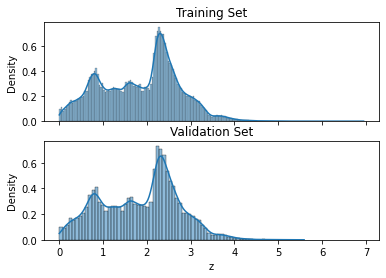

In [7]:
def plot_z_displot(z_first, z_second):
    fig, axs = plt.subplots(nrows=2, sharex=True)
    for ax, z in zip(axs, (z_first, z_second)):
        sns.histplot(
            z.squeeze().numpy(), ax=ax,
            kde=True, stat="density")
    return fig, axs

fig, axs = plot_z_displot(y, y_va)
axs[0].set_title("Training Set")
axs[1].set_title("Validation Set")
axs[1].set_xlabel("z")

<AxesSubplot:title={'center':'z_true = 2.0290'}, xlabel='wave', ylabel='flux'>

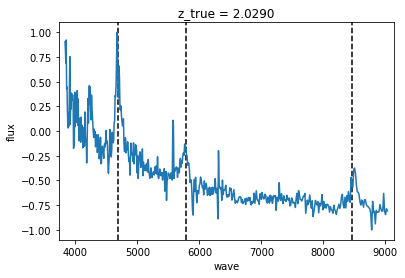

In [8]:
def plot_redshift(ax, z, z_std=None, color="k"):
    for line in spectral_lines.values():
        ax.axvline((1 + z) * line, color=color, linestyle="--")
        if z_std is not None:
            ax.fill_betweenx(
                [-1, 1],
                (1 + (z - 1.96 * z_std)) * line,
                (1 + (z + 1.96 * z_std)) * line,
                color=color, alpha=0.2)
    return ax

def plot_spec(flux, z_true, z_pred=None, z_std=None):
    ax = plt.axes(
        xlabel="wave", ylabel="flux",
        xlim=(10 ** LOGLAMMIN - 100, 10 ** LOGLAMMAX + 100))
    title = "z_true = {:.4f}".format(z_true)
    plot_redshift(ax, z_true)
    if z_pred is not None:
        title += ", z_pred = {:.4f}".format(z_pred)
        if z_std is not None:
            title += ", z_std = {:.4f}".format(z_std)
        plot_redshift(ax, z_pred, z_std, color="r")
    ax.plot(WAVES, flux)
    ax.set_title(title)
    return ax

rnd_idx = np.random.randint(X.shape[0])
plot_spec(X[rnd_idx], y[rnd_idx, 0])

## Fully Connected Neural Network

In [9]:
input_dim = X.shape[1]
input_dim

512

In [104]:
def predict(model, X):
    ds = TensorDataset(X)
    dl = DataLoader(ds, batch_size=1024, shuffle=False)
    with torch.no_grad():
        return torch.cat([model(xb.to(DEVICE)).cpu() for [xb] in dl])

def train(model, X, y, X_va, y_va, epochs, criterion=MSELoss(), weight_decay=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), weight_decay)
    ds = TensorDataset(X, y)
    dl = DataLoader(ds, batch_size=128, shuffle=True)
    losses, losses_va = torch.zeros(epochs), torch.zeros(epochs)

    for epoch in range(epochs):
        model.train()
        for xb, yb in dl:
            optimizer.zero_grad()
            loss = criterion(model(xb.to(DEVICE)), yb.to(DEVICE))
            loss.backward()
            optimizer.step()

        model.eval()
        losses[epoch] = criterion(predict(model, X), y)
        losses_va[epoch] = criterion(predict(model, X_va), y_va)

    return losses, losses_va

In [101]:
nn = Sequential(
    Linear(input_dim, 256, bias=True),
    ReLU(),
    Dropout(0.5),
    Linear(256, 128, bias=True),
    ReLU(),
    Dropout(0.5),
    Linear(128, 1, bias=True)
).to(DEVICE)

epochs = 50
losses, losses_va = train(nn, X, y, X_va, y_va, epochs)

# get number of parameters
sum(p.numel() for p in nn.parameters() if p.requires_grad)

164353

In [102]:
def plot_losses(losses, losses_va):
    fig, ax = plt.subplots()
    ax.set_xlabel("epoch")
    ax.set_ylabel("MSEloss")
    ax.plot(np.arange(1, epochs + 1), losses, label="validation loss")
    ax.plot(np.arange(1, epochs + 1), losses_va, label="training loss")
    ax.legend()
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='epoch', ylabel='MSEloss'>)

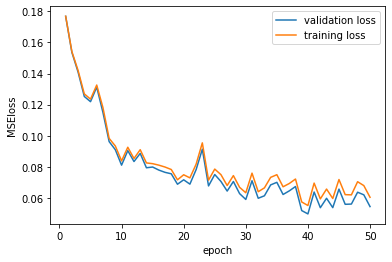

In [103]:
plot_losses(losses, losses_va)

Text(0.5, 1.0, 'Predictions')

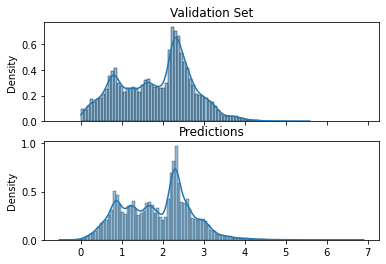

In [58]:
fig, axs = plot_z_displot(y_va, y_pred)
axs[0].set_title("Validation Set")
axs[1].set_title("Predictions")

<AxesSubplot:title={'center':'z_true = 2.3210, z_pred = 2.2922'}, xlabel='wave', ylabel='flux'>

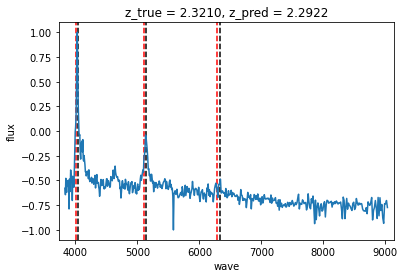

In [59]:
rnd_idx = np.random.randint(X_va.shape[0])
plot_spec(X_va[rnd_idx], y_va[rnd_idx, 0], y_pred[rnd_idx, 0])

In [60]:
y_pred = predict(nn, X_va)
rmse = partial(mean_squared_error, squared=False)
rmse(y_va, y_pred)

0.19625536

$\Delta v = c \frac{z - z_\mathrm{VI}}{1 + z_\mathrm{VI}}$

In [61]:
# speed of light in vacuum (unit km / s)
c = const.c.to("km / s").value

def delta_v(y_pred, y_va):
    return c * (torch.abs(y_pred - y_va) / (1 + y_va))

def catastrophic_redshift_ratio(y_pred, y_va):
    nn_delta_v = delta_v(y_pred, y_va)
    ratio = torch.sum(nn_delta_v > 3000) / nn_delta_v.size(0)
    return ratio.item()

catastrophic_redshift_ratio(y_pred, y_va)

0.6638200283050537

## Bayesian Neural Network

In [ ]:
# TODO see 5.7. Bayesian Neural Networks in Bishop: Pattern Recognition and Machine Learning

## Bayesian Deep Learning

- [Uncertainty in Deep Learning](http://www.cs.ox.ac.uk/people/yarin.gal/website/blog_2248.html)
- [Bayesian Deep Learning 101](http://www.cs.ox.ac.uk/people/yarin.gal/website/bdl101/)
- [MLSS 2019 Skoltech Tutorials](https://github.com/mlss-skoltech/tutorials)

### Approximating Bayesian Neural Network with Dropout

"Drawing a new function for each test point makes no difference if all we care about is obtaining the predictive mean and predictive variance (actually, for these two quantities this process is preferable to the one I will describe below), but this process does not result in draws from the induced distribution over functions." ([Uncertainty in Deep Learning](http://www.cs.ox.ac.uk/people/yarin.gal/website/blog_2248.html))

In [106]:
bnn = nn

In [105]:
def point_estimate(model, X, samples):
    model.train()
    outputs = torch.zeros(samples, X.size(0), 1)
    for i in range(samples):
        outputs[i] = predict(model, X)
    return outputs

samples = point_estimate(bnn, X_va, samples=128)
samples.size()

torch.Size([128, 50000, 1])

In [107]:
bnn_y_pred, bnn_std = samples.mean(dim=0), samples.std(dim=0)

In [108]:
rmse(bnn_y_pred, y_va), catastrophic_redshift_ratio(bnn_y_pred, y_va)

(0.23335439, 0.6587600111961365)

<AxesSubplot:title={'center':'z_true = 2.2790, z_pred = 2.2665, z_std = 0.2159'}, xlabel='wave', ylabel='flux'>

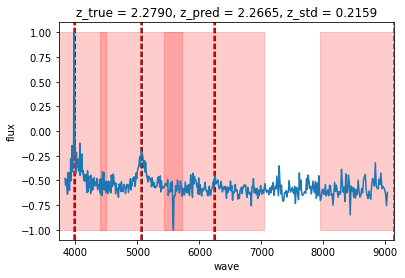

In [125]:
rnd_idx = np.random.randint(X_va.size(0))
plot_spec(X_va[rnd_idx], y_va[rnd_idx, 0], mean[rnd_idx, 0], std[rnd_idx, 0])

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       dtype=object))

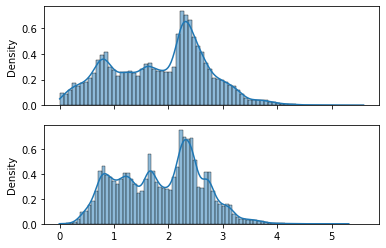

In [126]:
plot_z_displot(y_va, mean)

<AxesSubplot:ylabel='Count'>

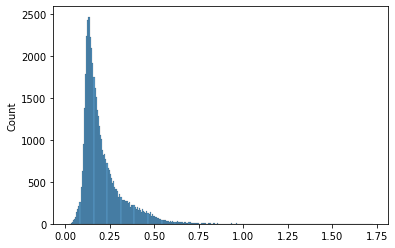

In [127]:
ax = plt.axes()
sns.histplot(std.squeeze().numpy(), ax=ax)

tensor(1.7290)


<AxesSubplot:title={'center':'z_true = 4.7780, z_pred = 5.3161, z_std = 1.7290'}, xlabel='wave', ylabel='flux'>

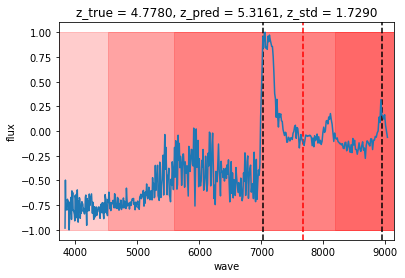

In [128]:
idx = std.argmax()
print(std.max())
plot_spec(X_va[idx], y_va[idx, 0], mean[idx, 0], std[idx, 0])

tensor(0.0200)


<AxesSubplot:title={'center':'z_true = 1.5390, z_pred = 1.6400, z_std = 0.0200'}, xlabel='wave', ylabel='flux'>

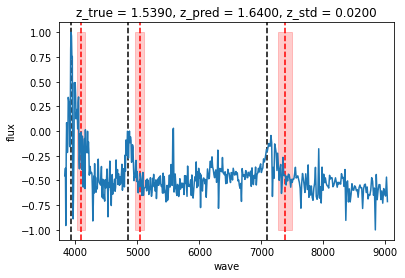

In [129]:
idx = std.argmin()
print(std.min())
plot_spec(X_va[idx], y_va[idx, 0], mean[idx, 0], std[idx, 0])